# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

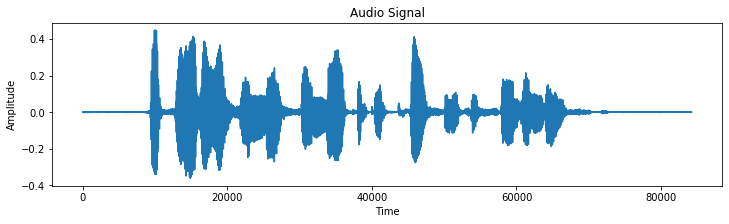

**Shape of Audio Signal** : (84231,)

**Transcript** : her father is a most remarkable person to say the least

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

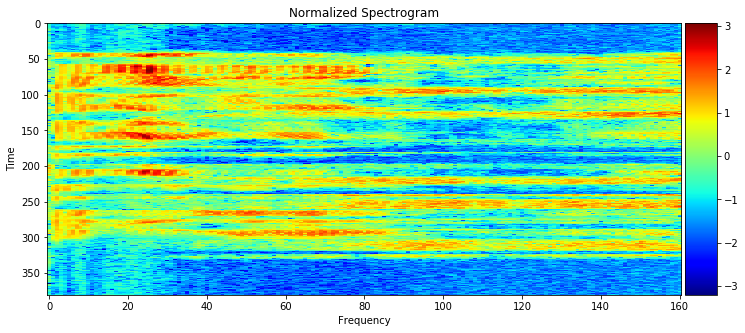

**Shape of Spectrogram** : (381, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

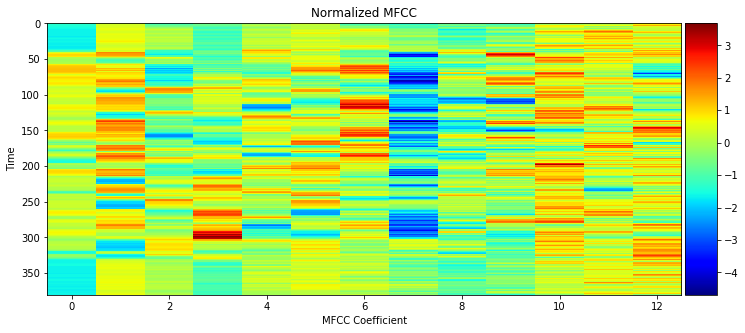

**Shape of MFCC** : (381, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.99
#set_session(tf.Session(config=config))
"""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
"""
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [9]:
model_0 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [8]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 179s 2s/step - loss: 844.6676 - val_loss: 662.1968
Epoch 2/20
101/101 [==============================] - 169s 2s/step - loss: 779.1799 - val_loss: 845.8187
Epoch 3/20
101/101 [==============================] - 167s 2s/step - loss: 779.0809 - val_loss: 765.2210
Epoch 4/20
101/101 [==============================] - 169s 2s/step - loss: 779.2441 - val_loss: 717.6456
Epoch 5/20
101/101 [==============================] - 171s 2s/step - loss: 779.0839 - val_loss: 799.6042
Epoch 6/20
101/101 [==============================] - 168s 2s/step - loss: 779.0798 - val_loss: 687.8724
Epoch 7/20
101/101 [==============================] - 169s 2s/step - loss: 778.9766 - val_loss: 799.2511
Epoch 8/20
101/101 [==============================] - 170s 2s/step - loss: 779.5769 - val_loss: 622.4951
Epoch 9/20
101/101 [==============================] - 169s 2s/step - loss: 779.2788 - val_loss: 718.6160
Epoch 10/20
101/101 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [10]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [18]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 174s 2s/step - loss: 308.0933 - val_loss: 191.0124
Epoch 2/20
101/101 [==============================] - 174s 2s/step - loss: 226.5304 - val_loss: 220.0268
Epoch 3/20
101/101 [==============================] - 175s 2s/step - loss: 201.9268 - val_loss: 264.1971
Epoch 4/20
101/101 [==============================] - 175s 2s/step - loss: 182.7022 - val_loss: 167.6539
Epoch 5/20
101/101 [==============================] - 174s 2s/step - loss: 169.8422 - val_loss: 165.7795
Epoch 6/20
101/101 [==============================] - 174s 2s/step - loss: 159.9299 - val_loss: 139.7128
Epoch 7/20
101/101 [==============================] - 173s 2s/step - loss: 152.3739 - val_loss: 154.5988
Epoch 8/20
101/101 [==============================] - 173s 2s/step - loss: 146.4858 - val_loss: 142.7924
Epoch 9/20
101/101 [==============================] - 173s 2s/step - loss: 141.7210 - val_loss: 161.4276
Epoch 10/20
101/101 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [11]:
model_2 = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
 model_2      spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 103s 1s/step - loss: 240.1889 - val_loss: 148.7251
Epoch 2/20
101/101 [==============================] - 98s 974ms/step - loss: 176.7420 - val_loss: 147.8697
Epoch 3/20
101/101 [==============================] - 100s 992ms/step - loss: 154.3363 - val_loss: 131.8793
Epoch 4/20
101/101 [==============================] - 100s 992ms/step - loss: 143.0670 - val_loss: 143.6557
Epoch 5/20
101/101 [==============================] - 98s 972ms/step - loss: 135.3881 - val_loss: 138.3237
Epoch 6/20
101/101 [==============================] - 98s 970ms/step - loss: 130.0959 - val_loss: 143.3701
Epoch 7/20
101/101 [==============================] - 101s 996ms/step - loss: 125.4712 - val_loss: 151.7583
Epoch 8/20
101/101 [==============================] - 98s 969ms/step - loss: 122.0085 - val_loss: 136.6344
Epoch 9/20
101/101 [==============================] - 98s 973ms/step - loss: 118.6612 - val_loss: 143.9280
Epoch 10/20
101/101 [===============

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [12]:
model_3 = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, None, 200)         128400    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 200)         800       
_________________________________________________________________
gru_5 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 429s 4s/step - loss: 277.5822 - val_loss: 250.2230
Epoch 2/20
101/101 [==============================] - 414s 4s/step - loss: 238.6454 - val_loss: 227.2230
Epoch 3/20
101/101 [==============================] - 414s 4s/step - loss: 225.6697 - val_loss: 217.9436
Epoch 4/20
101/101 [==============================] - 418s 4s/step - loss: 211.6332 - val_loss: 207.2416
Epoch 5/20
101/101 [==============================] - 414s 4s/step - loss: 187.8779 - val_loss: 200.0120
Epoch 6/20
101/101 [==============================] - 416s 4s/step - loss: 168.6194 - val_loss: 176.6169
Epoch 7/20
101/101 [==============================] - 416s 4s/step - loss: 155.1704 - val_loss: 153.9570
Epoch 8/20
101/101 [==============================] - 418s 4s/step - loss: 145.9678 - val_loss: 153.1238
Epoch 9/20
101/101 [==============================] - 416s 4s/step - loss: 138.9365 - val_loss: 148.7610
Epoch 10/20
101/101 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [13]:
model_4 = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 268,429
Trainable params: 268,429
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 259s 3s/step - loss: 323.4051 - val_loss: 160.3605
Epoch 2/20
101/101 [==============================] - 258s 3s/step - loss: 218.0265 - val_loss: 223.5869
Epoch 3/20
101/101 [==============================] - 258s 3s/step - loss: 204.0237 - val_loss: 162.4477
Epoch 4/20
101/101 [==============================] - 259s 3s/step - loss: 191.5277 - val_loss: 169.9546
Epoch 5/20
101/101 [==============================] - 259s 3s/step - loss: 181.4637 - val_loss: 156.4757
Epoch 6/20
101/101 [==============================] - 258s 3s/step - loss: 174.7491 - val_loss: 192.4393
Epoch 7/20
101/101 [==============================] - 259s 3s/step - loss: 169.2411 - val_loss: 150.6915
Epoch 8/20
101/101 [==============================] - 258s 3s/step - loss: 163.7799 - val_loss: 152.7845
Epoch 9/20
101/101 [==============================] - 258s 3s/step - loss: 159.7494 - val_loss: 139.9388
Epoch 10/20
101/101 [==============================] - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [14]:
model_5 = deep_bidir_model(input_dim=13, units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 58)          23258     
_________________________________________________________________
activation_2 (Activation)    (None, None, 58)          0         
Total params: 1,001,258
Trainable params: 1,001,258
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle',
           save_model_path="model_5.h5",
           spectrogram=False)

Epoch 1/20
101/101 [==============================] - 494s 5s/step - loss: 357.4994 - val_loss: 171.6991
Epoch 2/20
101/101 [==============================] - 489s 5s/step - loss: 229.2553 - val_loss: 203.6523
Epoch 3/20
101/101 [==============================] - 479s 5s/step - loss: 211.8191 - val_loss: 175.6905
Epoch 4/20
101/101 [==============================] - 479s 5s/step - loss: 197.1161 - val_loss: 180.9800
Epoch 5/20
101/101 [==============================] - 480s 5s/step - loss: 183.9961 - val_loss: 165.9480
Epoch 6/20
101/101 [==============================] - 480s 5s/step - loss: 173.5516 - val_loss: 157.9795
Epoch 7/20
101/101 [==============================] - 480s 5s/step - loss: 165.3464 - val_loss: 153.1704
Epoch 8/20
101/101 [==============================] - 479s 5s/step - loss: 158.7455 - val_loss: 133.0050
Epoch 9/20
101/101 [==============================] - 493s 5s/step - loss: 153.1336 - val_loss: 114.3638
Epoch 10/20
101/101 [==============================] - 

In [15]:
model_6 = deepbidir_deep_model(input_dim=13, units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 58)          23258     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 29)          1711      
_________________________________________________________________
activation_3 (Activation)    (None, None, 29)          0         
Total params: 1,002,969
Trainable params: 1,002,969
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle',
           save_model_path="model_6.h5",
           spectrogram=False)

Epoch 1/20
101/101 [==============================] - 489s 5s/step - loss: 320.6467 - val_loss: 188.0458
Epoch 2/20
101/101 [==============================] - 483s 5s/step - loss: 238.1914 - val_loss: 231.2646
Epoch 3/20
101/101 [==============================] - 479s 5s/step - loss: 221.9452 - val_loss: 205.4023
Epoch 4/20
101/101 [==============================] - 481s 5s/step - loss: 204.2233 - val_loss: 179.6567
Epoch 5/20
101/101 [==============================] - 488s 5s/step - loss: 189.0591 - val_loss: 146.9810
Epoch 6/20
101/101 [==============================] - 477s 5s/step - loss: 178.0443 - val_loss: 155.5882
Epoch 7/20
101/101 [==============================] - 481s 5s/step - loss: 169.5553 - val_loss: 163.5109
Epoch 8/20
101/101 [==============================] - 479s 5s/step - loss: 163.0181 - val_loss: 157.3986
Epoch 9/20
101/101 [==============================] - 481s 5s/step - loss: 157.7699 - val_loss: 141.7460
Epoch 10/20
101/101 [==============================] - 

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

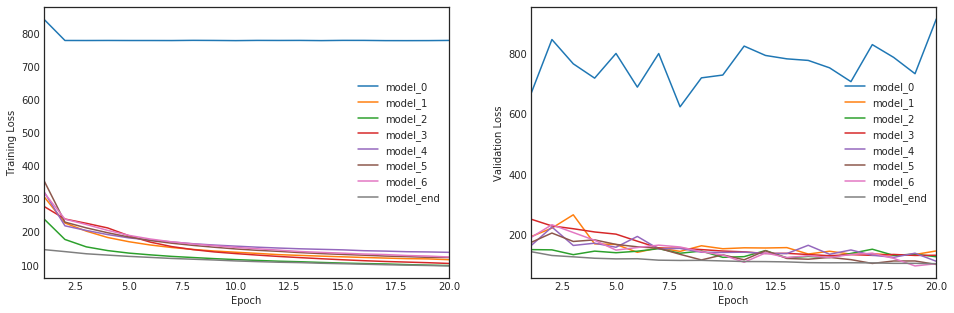

In [6]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.savefig("modelperformances.png")
plt.show()

In [7]:
minValidLosses = [min(losses) for losses in valid_loss]

In [16]:
models = list()
models.extend([model_0, model_1, model_2, model_3, model_4,
               model_5, model_6, model_end])

In [17]:
paramcounts = [model.count_params() for model in models] 

In [18]:
minValidLosses

[622.4950561523438,
 130.63150024414062,
 121.42707824707031,
 128.43155333816364,
 109.83685302734375,
 99.28324127197266,
 94.46908569335938,
 101.92131460866621]

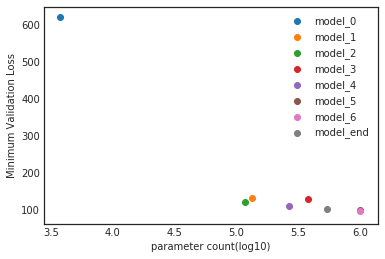

In [19]:
for i in range(len(all_pickles)):
    plt.scatter( np.log10(paramcounts[i]), minValidLosses[i])
plt.legend(labels = model_names)
plt.xlabel("parameter count(log10)")
plt.ylabel("Minimum Validation Loss")
plt.savefig("paramCount Vs minValLoss.png")
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__
Using the additional plot i have above(**minimum validation loss vs parameter count**), I get my best performance from the deep bidirectional models. I however can observe the pretty good performance of the model that has utilizes a CNN, suggesting that using a CNN as a feature extractor is probably a good idea. There is generally a correlation between the number of parameters a model has and how well it performs.
In addition, i can observe a very significant amount of overfitting in some models. The CNN model for example has a very low training loss, but on the other hand performs more poorly at validation time than other models.
**Model_0**: This basic model consist of a single RNN. Its performance suggests this model's architecture is unable to sufficiently learn and model the data therein.
**Model_1**: The model includes a Batch normalization layer and a TimeDistributed Dense layer after the GRU. The time distributed layer runs the output through the dense layer for every input while the Batch normalization scales our input to have zero mean and unit variance which allowed our model to learn much better.
**Model_2**: Model 2 features a CNN as a feature extractor. This model has a really good performance(compared to prior models), and suggests that it might be a good idea to use CNNs for this purpose.
**Model_3**: For this model, i remove the CNN for feature extraction, and use just RNNs. I observe really good performance suggesting that RNNs are almost comparatively as good a feature extractor(albeit with the consequence of almost tripling the number of parameters). 
**Model_4** We are able to improve the performance of our model by using a bidirectional RNN to go through the input vectors both forward and backwards. This has a perceptible improvement in the minimum validation loss, and suggests the next direction i would proceed with subsequent models.
**Model_5 and 6** With this models, i stack my bidirectional layers and time_distributed layers. Deeper networks improve my model's accuracy, albeit with an increasing number of parameters that consequently impact my training and inference time.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.99
#set_session(tf.Session(config=config))
#"""
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print(physical_devices)
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#"""
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


In [3]:
# specify the model
model_end = final_model(input_dim=13,
                        filters=150,
                        kernel_size=11, 
                        conv_stride=3,
                        conv_border_mode='same', 
                        units=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 150)         21600     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 150)         600       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         150600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [ ]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False,
            epochs=30) # change to False if you would like to use MFCC features 

Epoch 1/30
101/101 [==============================] - 429s 4s/step - loss: 247.7296 - val_loss: 208.7033
Epoch 2/30
101/101 [==============================] - 429s 4s/step - loss: 203.4231 - val_loss: 178.9659
Epoch 3/30
101/101 [==============================] - 426s 4s/step - loss: 176.0958 - val_loss: 156.0872
Epoch 4/30
101/101 [==============================] - 430s 4s/step - loss: 160.8105 - val_loss: 145.6738
Epoch 5/30
101/101 [==============================] - 429s 4s/step - loss: 150.9996 - val_loss: 139.0062
Epoch 6/30
 17/101 [====>.........................] - ETA: 4:51 - loss: 152.7435

In [4]:
model_end.load_weights("results/model_end.h5")

In [5]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=False,
            epochs=20)

Epoch 1/20
101/101 [==============================] - 419s 4s/step - loss: 146.0534 - val_loss: 142.0885
Epoch 2/20
101/101 [==============================] - 414s 4s/step - loss: 139.9499 - val_loss: 129.1827
Epoch 3/20
101/101 [==============================] - 416s 4s/step - loss: 133.4118 - val_loss: 124.7014
Epoch 4/20
101/101 [==============================] - 416s 4s/step - loss: 129.3735 - val_loss: 120.0170
Epoch 5/20
101/101 [==============================] - 415s 4s/step - loss: 125.5375 - val_loss: 117.9372
Epoch 6/20
101/101 [==============================] - 419s 4s/step - loss: 122.3903 - val_loss: 118.4398
Epoch 7/20
101/101 [==============================] - 419s 4s/step - loss: 119.2360 - val_loss: 113.6073
Epoch 8/20
101/101 [==============================] - 420s 4s/step - loss: 116.9101 - val_loss: 112.7179
Epoch 9/20
101/101 [==============================] - 416s 4s/step - loss: 114.5633 - val_loss: 113.0166
Epoch 10/20
101/101 [==============================] - 

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__ My final architecture has 3 layers of bidirectional GRUs. This is because in my prior experiments, i observe that bidirectional layers provide the best performance for this kind of problems  with a significant drop in validation loss being observed for each bi-directional layer added. This led me to stack 3 bidirectional GRUs for feature extraction and then to use a FC layer for prediction. Since I previously observe good performance with minimal increase in parameter count from having used a 1D convolution prior to using the RNN, i stuck to that approach.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [20]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [21]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
    filters=150,
    kernel_size=11,
    conv_stride=3,
    conv_border_mode='same',
    units=100), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 150)         21600     
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 150)         600       
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 200)         150600    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 200)         800       
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [22]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=13, # change to 13 if you would like to use MFCC features
    filters=150,
    kernel_size=11,
    conv_stride=3,
    conv_border_mode='same',
    units=100), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 150)         21600     
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 150)         600       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 200)         150600    
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 200)         800       
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 200)         180600    
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 200)         800       
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!